# Workout data extraction and visualisation

- Import data from cloud

- Explore and process the data
- Visualise the data

## Set up workspace and Import Data

In [32]:
# Set up workspace

libraries_installed = False

libraries = {
    "numpy": "np",
    "pandas": "pd",
    "matplotlib.pyplot": "plt",
    "matplotlib.dates": "mdates",
    "seaborn": "sns"
}

for lib, alias in libraries.items():
    try:
        # Dynamically import the library or submodule
        if '.' in lib:
            module = __import__(lib, fromlist=[lib.split('.')[-1]])
        else:
            module = __import__(lib)
        globals()[alias] = module  # Assign the imported library or submodule to the alias
    except ImportError:
        # Install the entire library as is
        base_package = lib.split('.')[0] if '.' in lib else lib
        print(f"{base_package} is not installed. Installing...")
        !pip install {base_package}
        libraries_installed = True

print("\nRestart Kernel as libraries were installed!") if libraries_installed else print("No libraries installed!")

No libraries installed!


In [35]:
# download excel file
download_link = 'https://docs.google.com/spreadsheets/d/1-0gquROk1n-UWdteg5P49QceZ49pPqDZ/export?format=csv'

df = pd.read_csv(download_link) # reads the binary excel data as if it were a file and saves as a dataframe

print(df.head())
print(df.shape)

         date            exercise variation  weight_kg  reps  sets  \
0  14/10/2021             Pullups       NaN        1.0    10     2   
1  14/10/2021             Pullups       NaN        1.0     7     2   
2  14/10/2021             Pullups       NaN        1.0     5     2   
3  14/10/2021             Pullups       NaN        1.0     6     1   
4  17/10/2021  Bent Row (Barbell)       NaN       85.0     3     4   

   total_reps  total_volume  notes  
0        20.0          20.0    NaN  
1        14.0          14.0    NaN  
2        10.0          10.0    NaN  
3         6.0           6.0    NaN  
4        12.0        1020.0    NaN  
(352, 9)


## Pre-process the data

In [18]:
# drop the columns we don't want

variables = df.columns.to_list()
print(variables)

variables = [ col for col in variables if col != 'notes' and col != 'variation' and col != 'total_volume' and col != 'total_reps']
df = df[variables]
print(variables)

['date', 'exercise', 'variation', 'weight_kg', 'reps', 'sets', 'total_reps', 'total_volume', 'notes']
['date', 'exercise', 'weight_kg', 'reps', 'sets']


In [36]:
# convert dates to datatime in pandas

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
print(df.head())


        date            exercise variation  weight_kg  reps  sets  total_reps  \
0 2021-10-14             Pullups       NaN        1.0    10     2        20.0   
1 2021-10-14             Pullups       NaN        1.0     7     2        14.0   
2 2021-10-14             Pullups       NaN        1.0     5     2        10.0   
3 2021-10-14             Pullups       NaN        1.0     6     1         6.0   
4 2021-10-17  Bent Row (Barbell)       NaN       85.0     3     4        12.0   

   total_volume  notes  
0          20.0    NaN  
1          14.0    NaN  
2          10.0    NaN  
3           6.0    NaN  
4        1020.0    NaN  


In [37]:
# extract dumbell exercises to accurately calculate volume
df['exercise'] = df['exercise'].str.lower() # convert values to lower
exercises = sorted(list(set(df['exercise'])))
print(exercises)

dumbell_exercises = [exercise for exercise in exercises if "dumbell" in exercise] # create list of dumbell exercises

print(dumbell_exercises)

['bench (barbell)', 'bench (dumbell)', 'bent row (barbell)', 'bent row (dumbell)', 'bicep curl (dumbell)', 'calf raise', 'deadlift', 'dips', 'front squat', 'hammer curl (dumbell)', 'incline bench (barbell)', 'incline press (dumbell)', 'ohp (barbell)', 'ohp (dumbell)', 'pullups', 'rdl', 'rear raise (dumbell)', 'shrug (dumbell)', 'side raise (dumbell)', 'skull crusher (dumbell)', 'squat', 'upright row']
['bench (dumbell)', 'bent row (dumbell)', 'bicep curl (dumbell)', 'hammer curl (dumbell)', 'incline press (dumbell)', 'ohp (dumbell)', 'rear raise (dumbell)', 'shrug (dumbell)', 'side raise (dumbell)', 'skull crusher (dumbell)']


In [38]:
# the total_reps and total_volume columns sometimes format incorrectly, so we will recreate them here

df['total_reps'] = df['reps'] * df['sets']
df['volume'] =  np.where(
    df['exercise'].isin(dumbell_exercises),
    df['total_reps'] * df['weight_kg'] * 2, 
    df['total_reps'] * df['weight_kg']
)
dumbells = df[df['exercise'].isin(dumbell_exercises)]
print(df.head(50))

         date                 exercise        variation  weight_kg  reps  \
0  2021-10-14                  pullups              NaN        1.0    10   
1  2021-10-14                  pullups              NaN        1.0     7   
2  2021-10-14                  pullups              NaN        1.0     5   
3  2021-10-14                  pullups              NaN        1.0     6   
4  2021-10-17       bent row (barbell)              NaN       85.0     3   
5  2021-10-17       bent row (barbell)  under-hand grip       85.0     3   
6  2021-10-20                  pullups              NaN       10.0     5   
7  2021-10-20                  pullups              NaN       10.0     4   
8  2021-10-20                  pullups              NaN       10.0     1   
9  2021-10-24          bench (barbell)              NaN       95.0     1   
10 2021-10-24          bench (barbell)              NaN      100.0     1   
11 2021-10-25  incline bench (barbell)              NaN       75.0     2   
12 2021-10-2

22


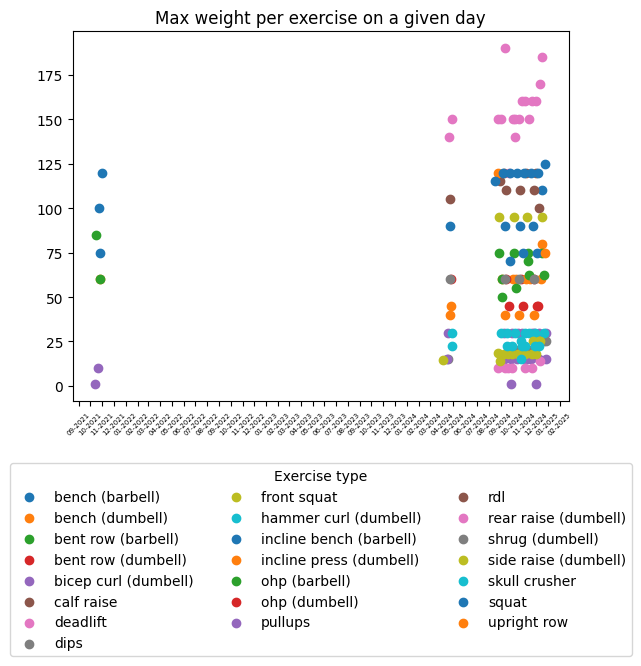

In [22]:
# create some useful df for plots
exercise_count = len(exercises)
date = df['date']


print(exercise_count)



# group date and exercise, select the index with the max weight value
max_weight_indices =  df.groupby(['date', 'exercise'])['weight_kg'].idxmax()

# create a df with only the max weight entry for each exercise on each day

df_max_weight = df.loc[max_weight_indices]

# weight needs to be doubled for dumbell exercises to account for the implied understanding that 2 dumbells are used
df_max_weight['weight_kg'] =  np.where(
    df_max_weight['exercise'].isin(dumbell_exercises),
    df_max_weight['weight_kg'] * 2, 
    df_max_weight['weight_kg']
)

for exercise in exercises:
    subset = df_max_weight[df_max_weight['exercise'] == exercise]
    plt.scatter(subset['date'], subset['weight_kg'], label=exercise)

plt.title('Max weight per exercise on a given day')
plt.legend(title='Exercise type')
plt.legend(title='Exercise type', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  
plt.xticks(rotation=45, fontsize=5)
plt.show()

          date  exercise variation  weight_kg  reps  sets  total_reps  \
41  2024-01-11  deadlift       NaN      140.0     5     5          25   
52  2024-01-22  deadlift       NaN      180.0     1     1           1   
75  2024-01-30  deadlift       NaN      140.0     8     1           8   
89  2024-04-20  deadlift       NaN      140.0     5    10          50   
106 2024-04-28  deadlift       NaN      150.0     6     1           6   
108 2024-08-24  deadlift       NaN      150.0     5     6          30   
121 2024-09-02  deadlift       NaN      150.0     5     7          35   
138 2024-09-11  deadlift       NaN      190.0     1     1           1   
156 2024-09-21  deadlift       NaN      120.0    10    12         120   
171 2024-10-02  deadlift       NaN      150.0     5     5          25   
177 2024-10-08  deadlift       NaN      150.0     9     1           9   
178 2024-10-09  deadlift       NaN      140.0     6     2          12   
192 2024-10-18  deadlift       NaN      150.0     5

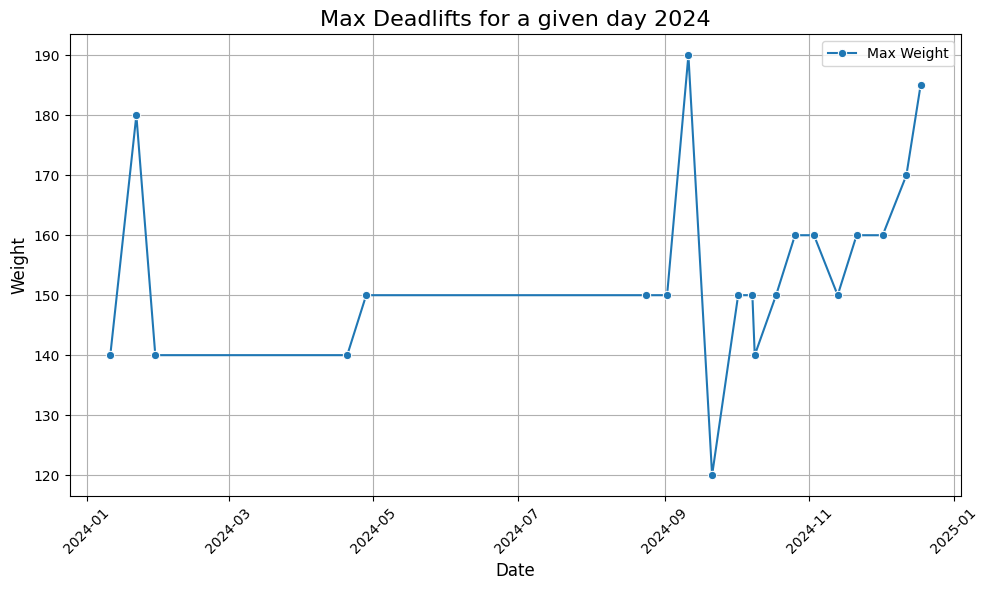

In [43]:
# create a plot visualising deadlift progression for the year 2024

# create a df containing deadlift and dates from 2024
deadlift_max_2024 = df[
    (df['exercise'] == 'deadlift') &
    (df['date'] >= '2024-01-01' ) &
    (df['date'] <= '2024-12-31' )
     ]

# group the entries by date and only select the one with the highest value for weight_kg
deadlift_max_2024 = deadlift_max_2024.loc[deadlift_max_2024.groupby('date')['weight_kg'].idxmax()]

print(deadlift_max_2024)

# Line plot for date vs. weight
plt.figure(figsize=(10, 6))
sns.lineplot(data=deadlift_max_2024, x='date', y='weight_kg', marker='o', label='Max Weight')

# Add titles and labels
plt.title('Max Deadlifts for a given day 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weight', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# LETS ADD ANOTHER LINE THAT PLOTS TOTAL VOLUME FOR DEADLIFT ON EACH OF THESE DAYS TO COMPARE THE RELATIONSHIP


         date  total_volume
0  2024-01-11        3500.0
1  2024-01-22        1440.0
2  2024-01-30        2840.0
3  2024-04-20        7000.0
4  2024-04-28         900.0
5  2024-08-24        4500.0
6  2024-09-02        5250.0
7  2024-09-11         190.0
8  2024-09-21       14400.0
9  2024-10-02        3750.0
10 2024-10-08        1350.0
11 2024-10-09        5880.0
12 2024-10-18        7500.0
13 2024-10-26        1440.0
14 2024-11-03         960.0
15 2024-11-13         750.0
16 2024-11-21        1920.0
17 2024-12-02       10000.0
18 2024-12-12         510.0
19 2024-12-18         185.0


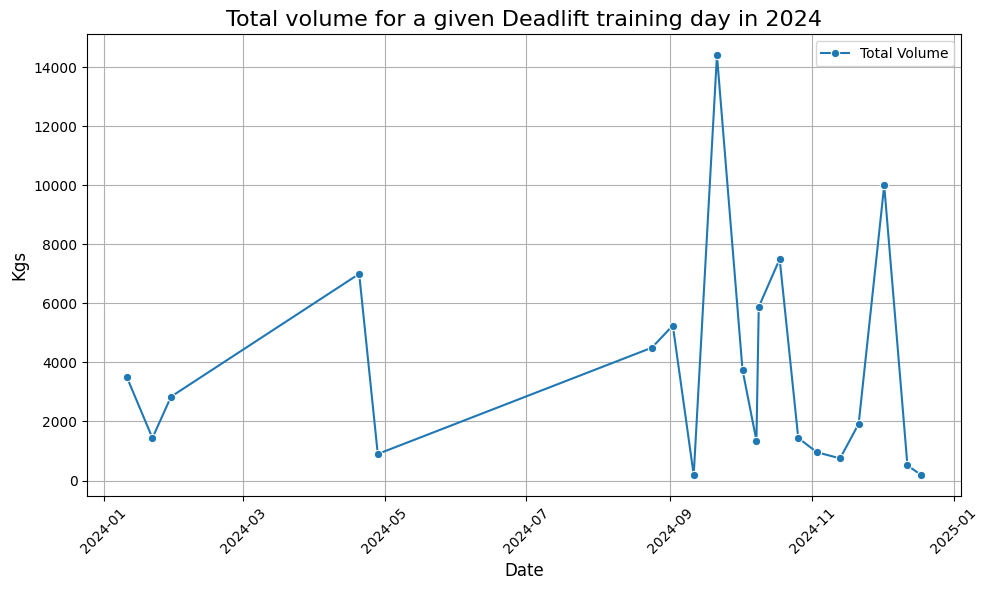

In [45]:
# create a plot visualising deadlift volume for a given day in 2024
deadlift_volume_2024 =  df[
    (df['exercise'] == 'deadlift') &
    (df['date'] >= '2024-01-01' ) &
    (df['date'] <= '2024-12-31' )
     ]


deadlift_volume_2024 = deadlift_volume_2024.groupby('date', as_index=False)['volume'].sum()
deadlift_volume_2024 = deadlift_volume_2024.rename(columns={'volume': 'total_volume'})
                                                          
print(deadlift_volume_2024)

# Line plot for total volume per day
plt.figure(figsize=(10, 6))
sns.lineplot(data=deadlift_volume_2024, x='date', y='total_volume', marker='o', label='Total Volume')

# Add titles and labels
plt.title('Total volume for a given Deadlift training day in 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Kgs', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

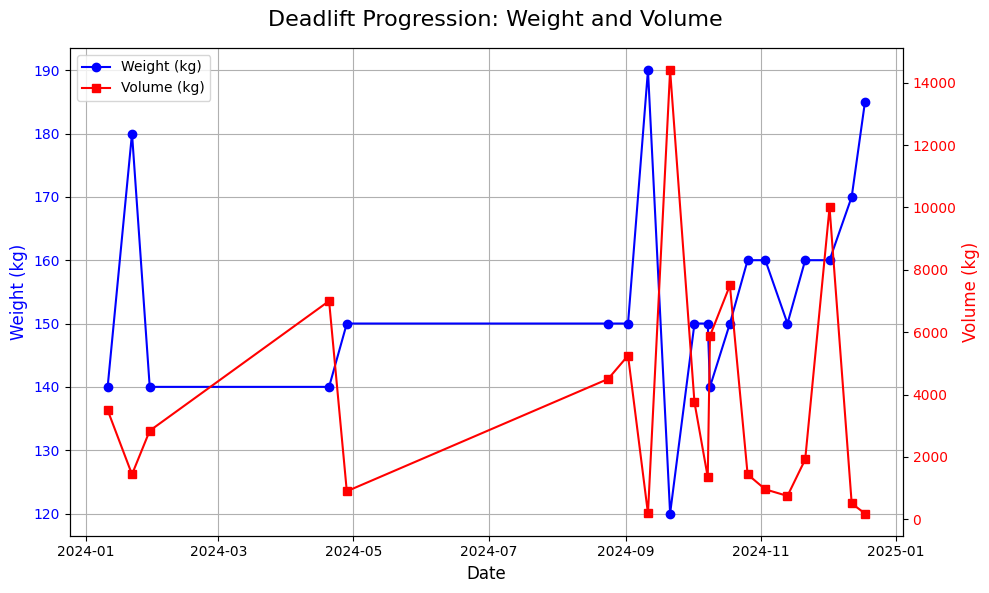

In [46]:
# Plotting both volume and max weight for deadlift

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first DataFrame (weight) on the left y-axis
ax1.plot(deadlift_max_2024['date'], deadlift_max_2024['weight_kg'], color='blue', marker='o', label='Weight (kg)')
ax1.set_ylabel('Weight (kg)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Date', fontsize=12)
ax1.grid(True)

# Create the second y-axis sharing the same x-axis
ax2 = ax1.twinx()  # This creates a second y-axis
ax2.plot(deadlift_volume_2024['date'], deadlift_volume_2024['total_volume'], color='red', marker='s', label='Volume (kg)')
ax2.set_ylabel('Volume (kg)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and legends
fig.suptitle('Deadlift Progression: Weight and Volume', fontsize=16)
fig.tight_layout()  # Adjust layout to prevent overlap

# Add a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

          date                 exercise variation  weight_kg  reps  sets  \
107 2024-08-17                    squat       NaN      115.0     5    10   
108 2024-08-24                 deadlift       NaN      150.0     5     6   
109 2024-08-25     side raise (dumbell)       NaN        9.2    15    10   
110 2024-08-25     rear raise (dumbell)       NaN        5.0    15    10   
111 2024-08-26  incline press (dumbell)       NaN       30.0     8    15   
..         ...                      ...       ...        ...   ...   ...   
347 2024-12-27                  pullups       NaN       15.0     3     1   
348 2024-12-28                     dips       NaN       25.0    10     5   
349 2024-12-28                     dips       NaN       25.0     6     1   
350 2024-12-28     bicep curl (dumbell)       NaN       15.0    10     6   
351 2024-12-29               calf raise       NaN      120.0    16     5   

     total_reps  total_volume  notes  volume  
107          50        5750.0    NaN  57

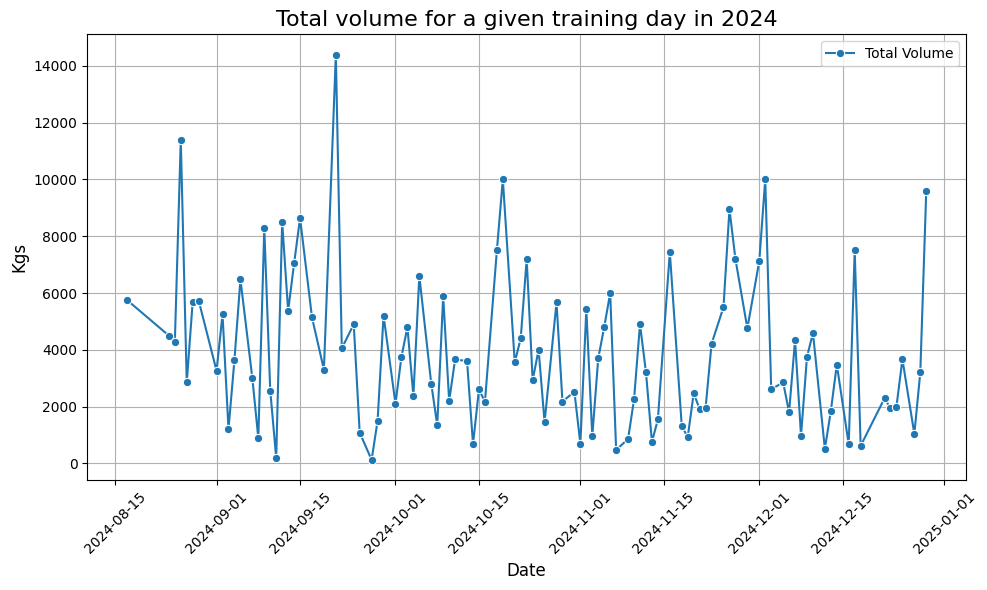

In [40]:
# create a plot visualising total training volume for a given day in 2024
total_volume_per_day =  df[
    (df['date'] >= '2024-08-01' ) &
    (df['date'] <= '2024-12-31' )
     ]

print(total_volume_per_day)

total_volume_per_day = total_volume_per_day.groupby('date', as_index=False)['volume'].sum()
total_volume_per_day = total_volume_per_day.rename(columns={'volume': 'total_volume'})
                                                          
print(total_volume_per_day)

# Line plot for total volume per day
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_volume_per_day, x='date', y='total_volume', marker='o', label='Total Volume')

# Add titles and labels
plt.title('Total volume for a given training day in 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Kgs', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.tight_layout()
plt.show()


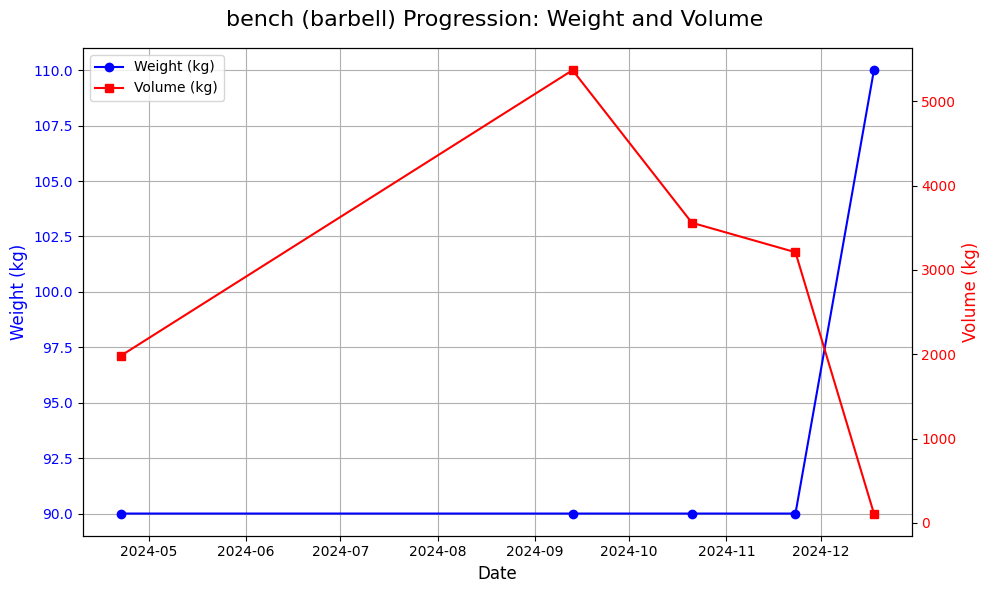

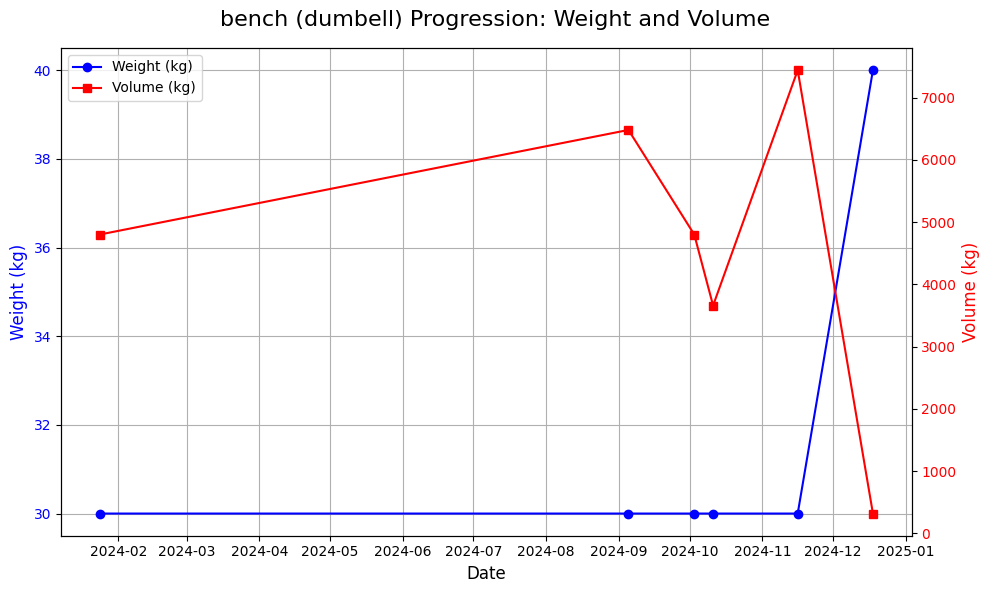

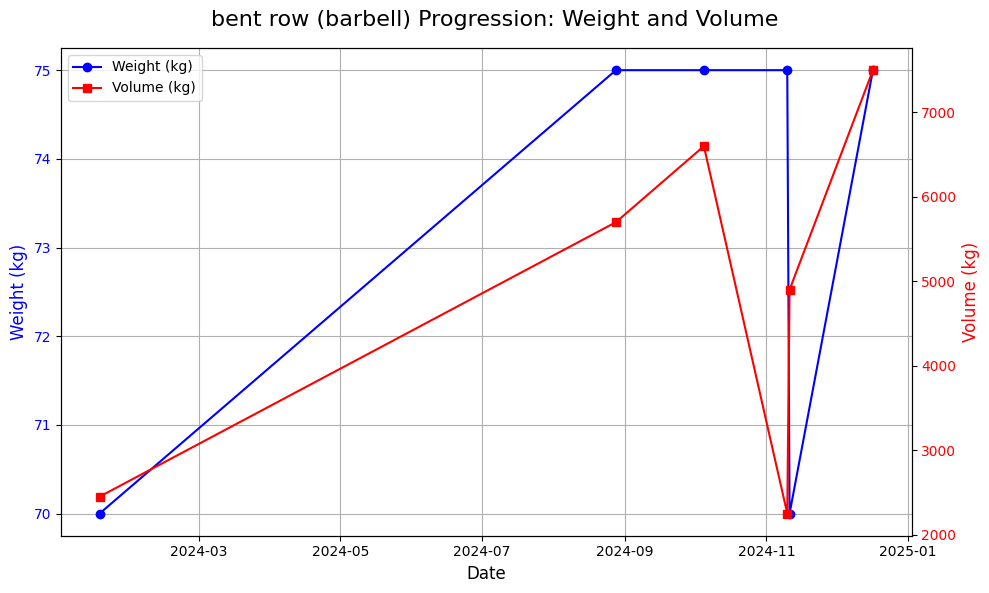

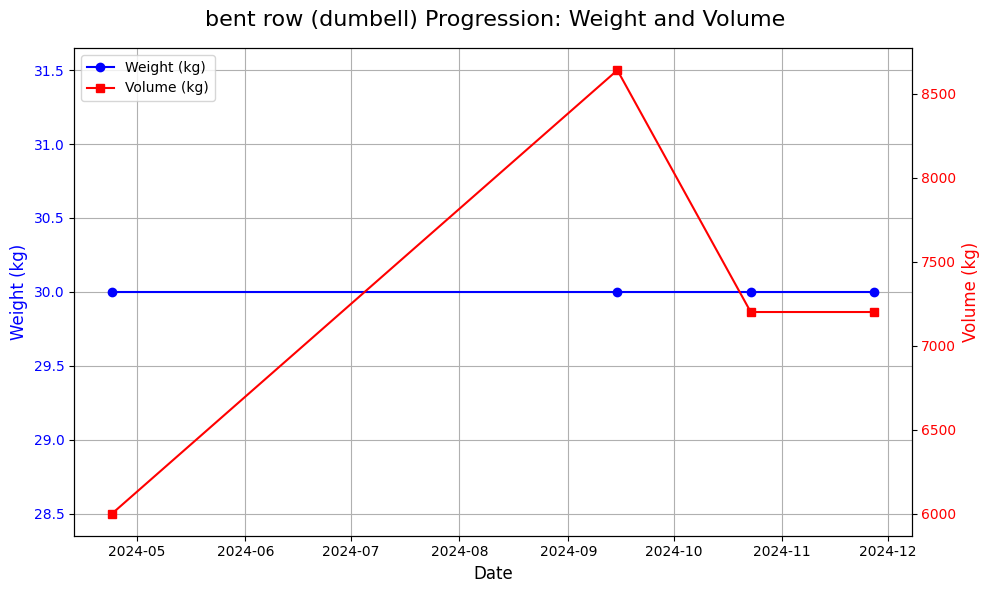

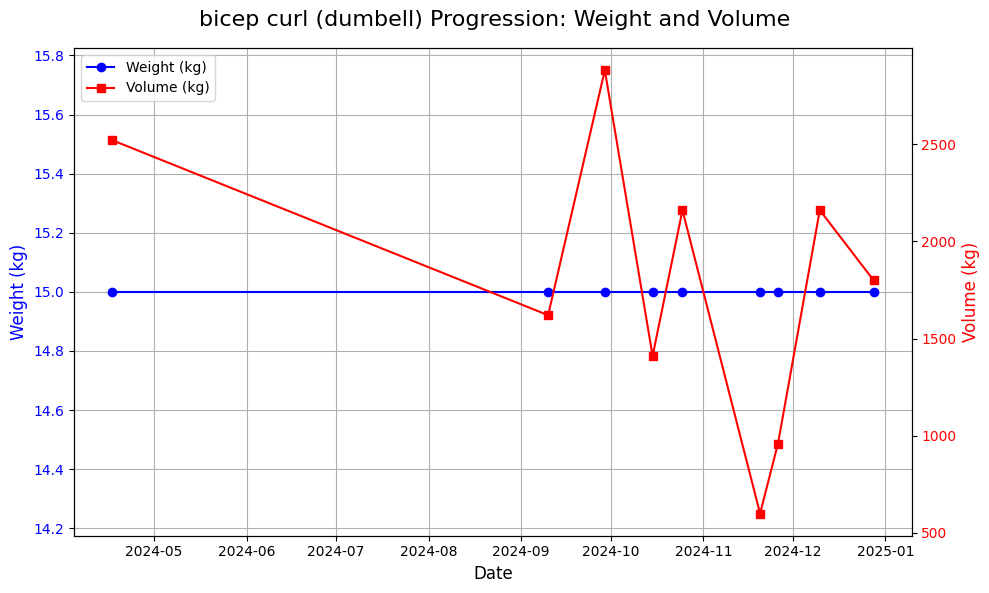

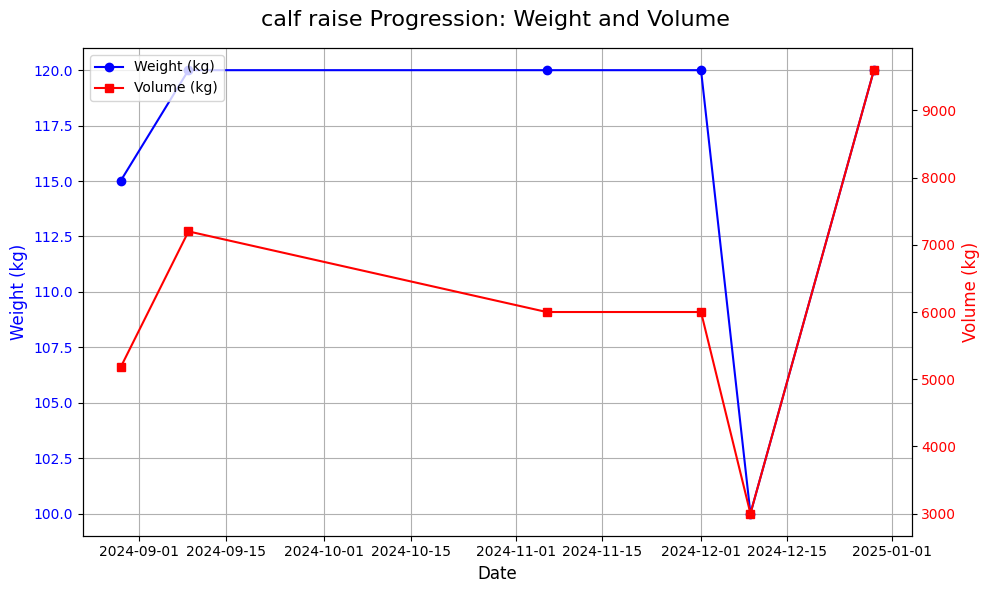

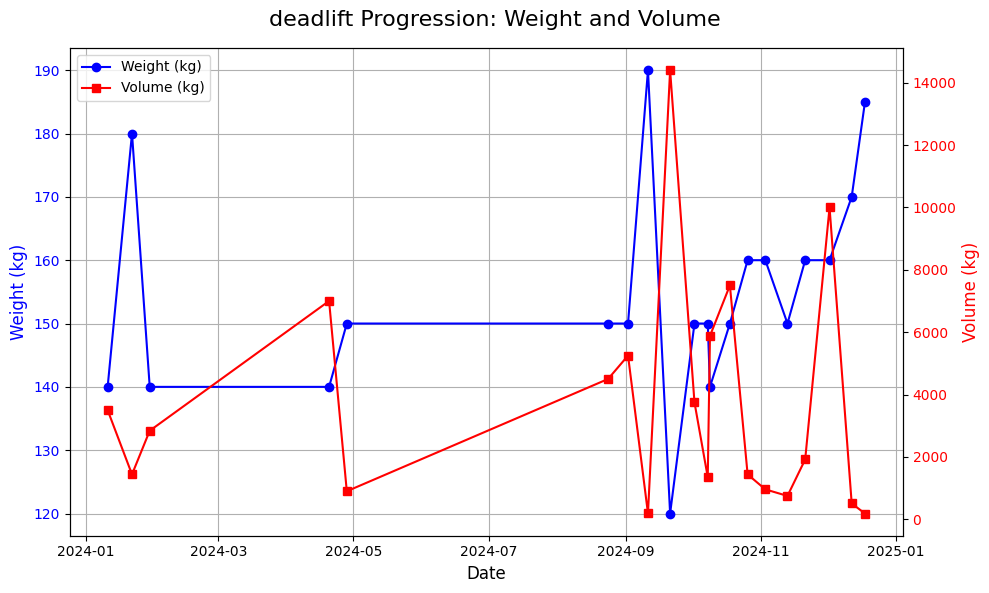

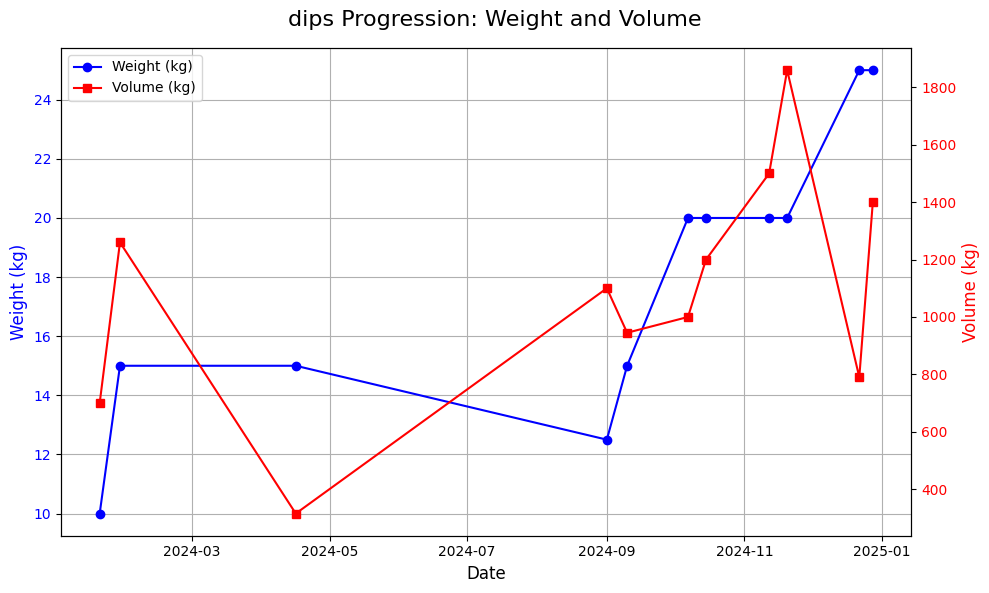

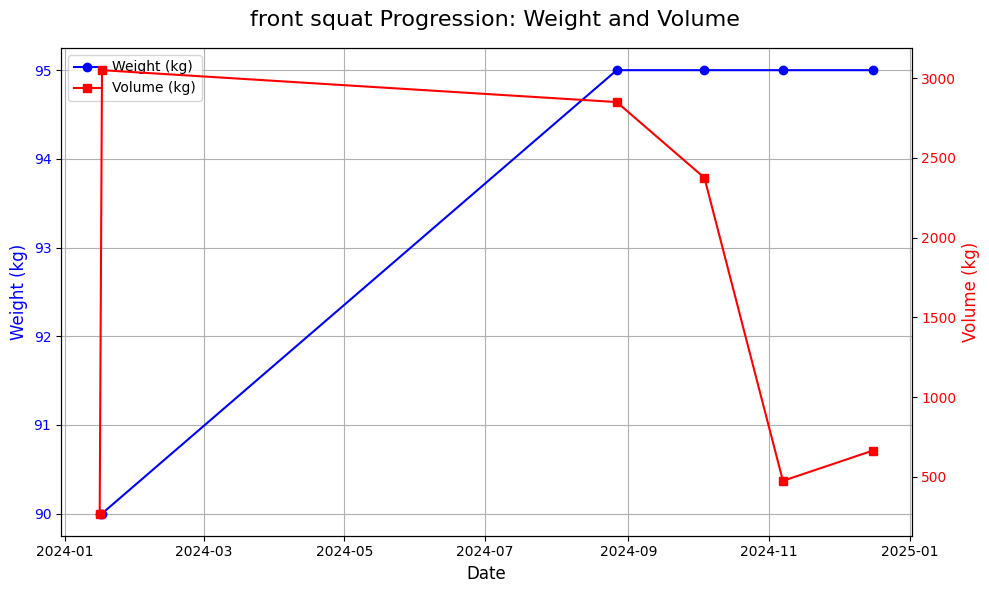

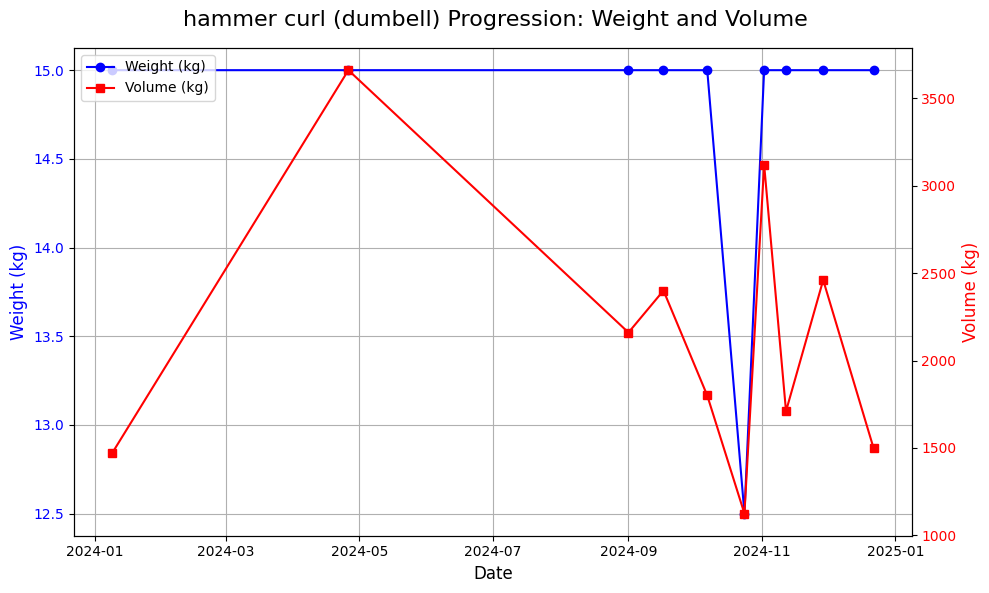

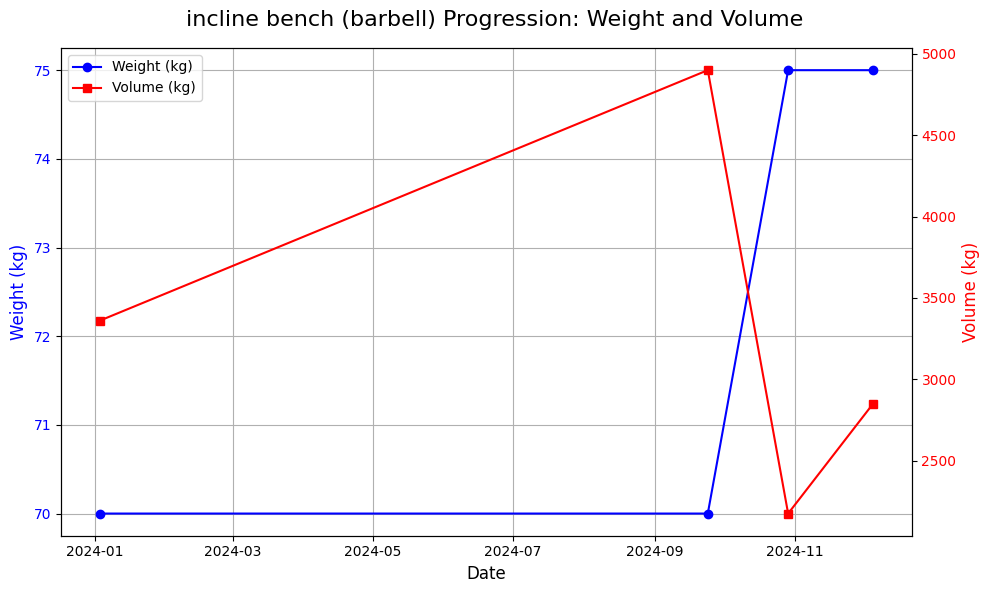

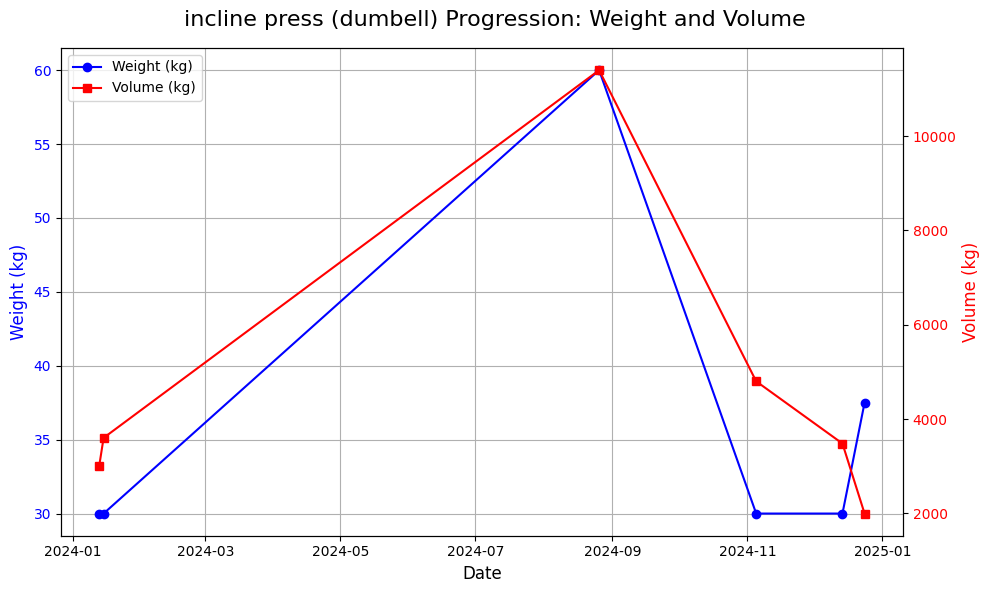

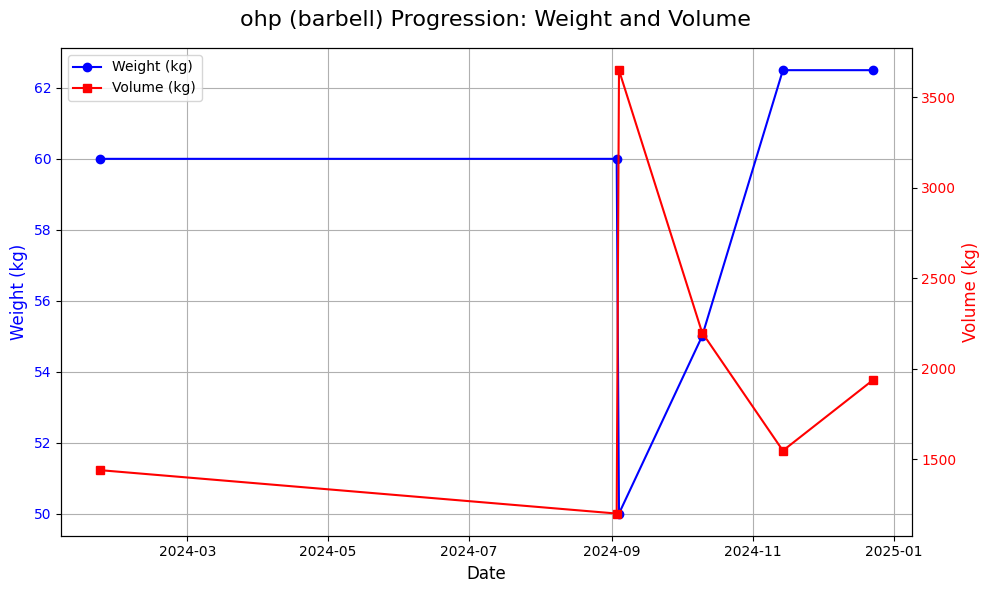

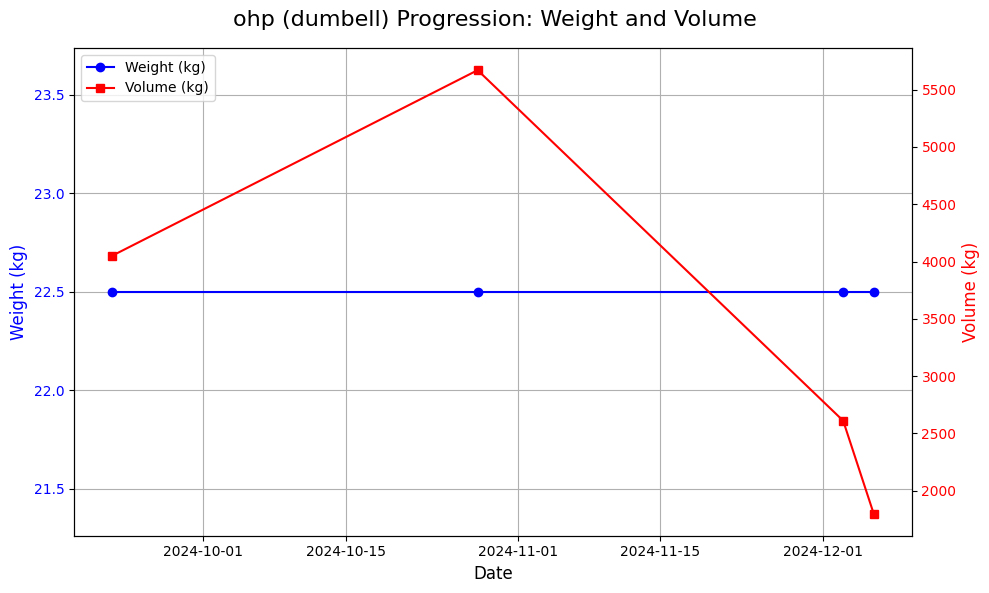

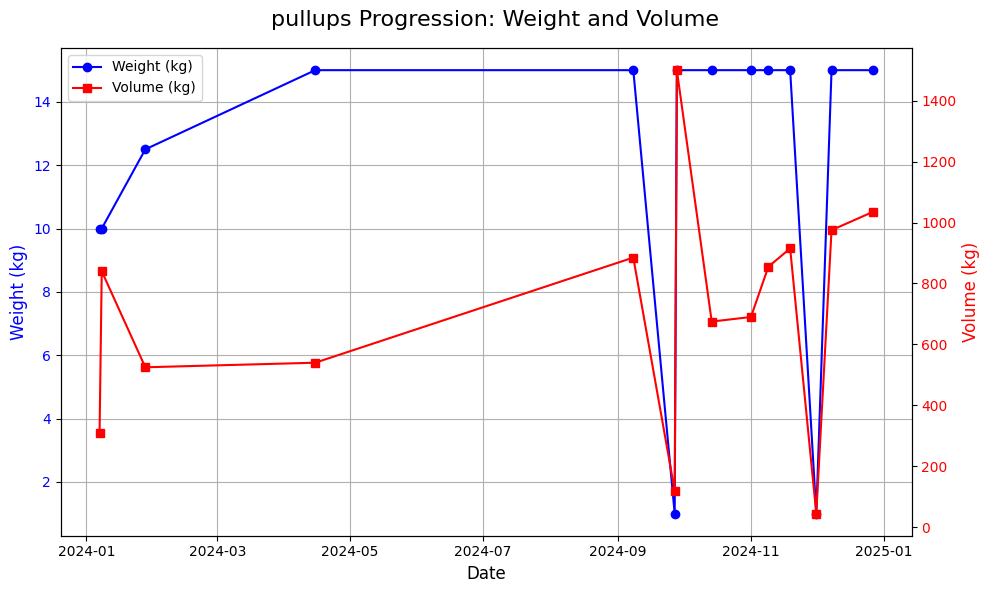

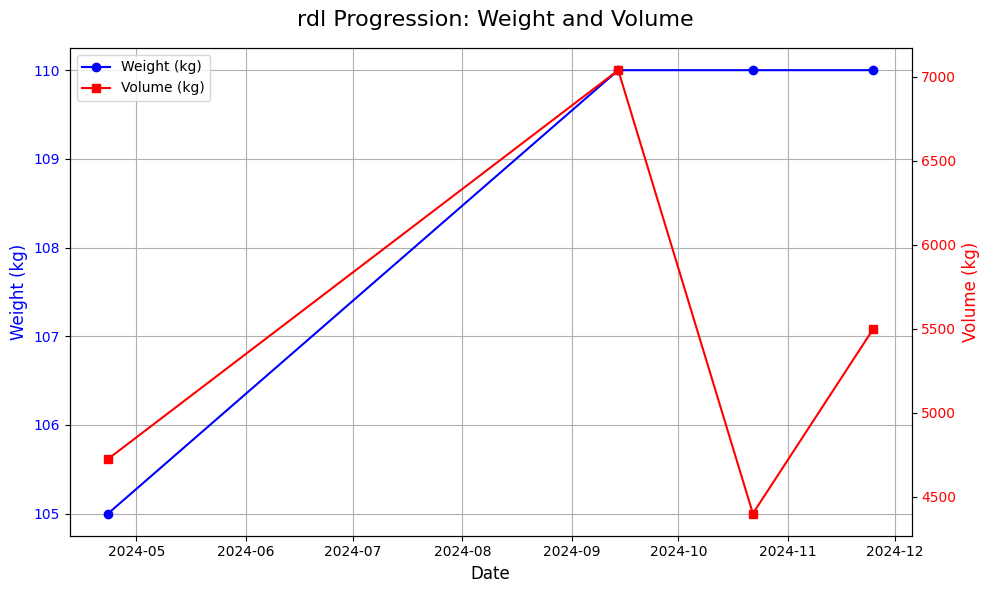

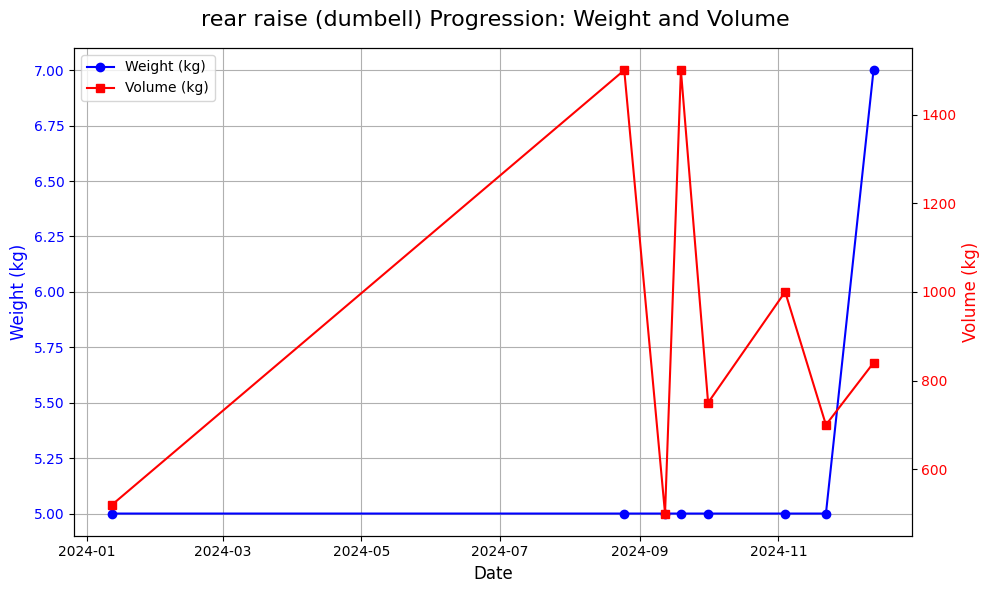

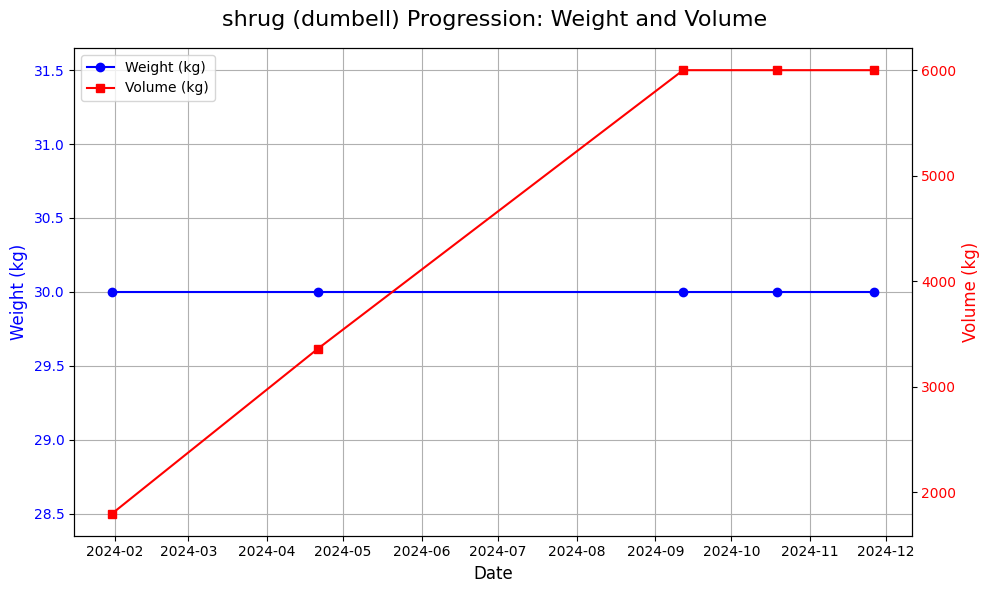

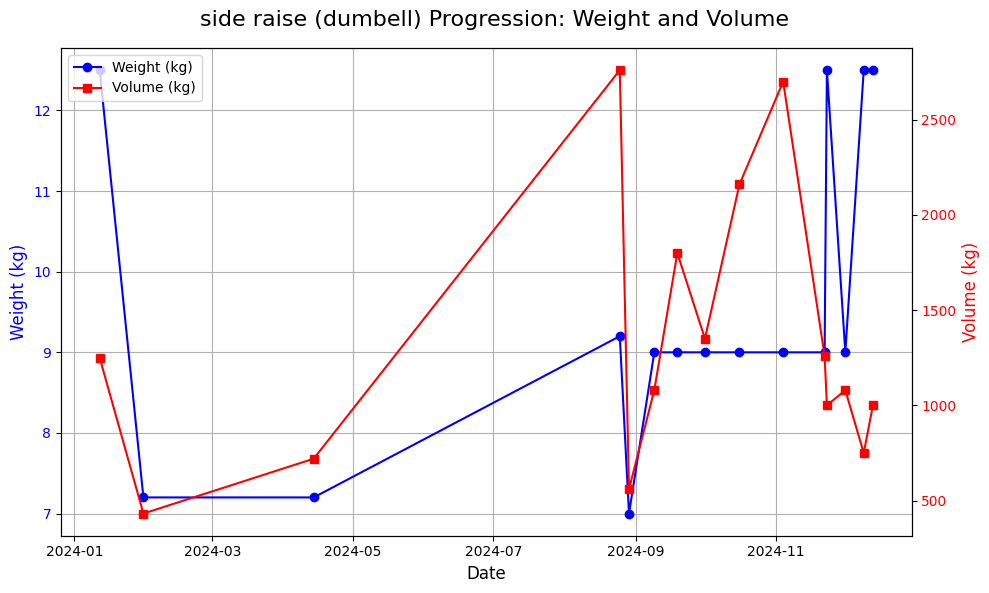

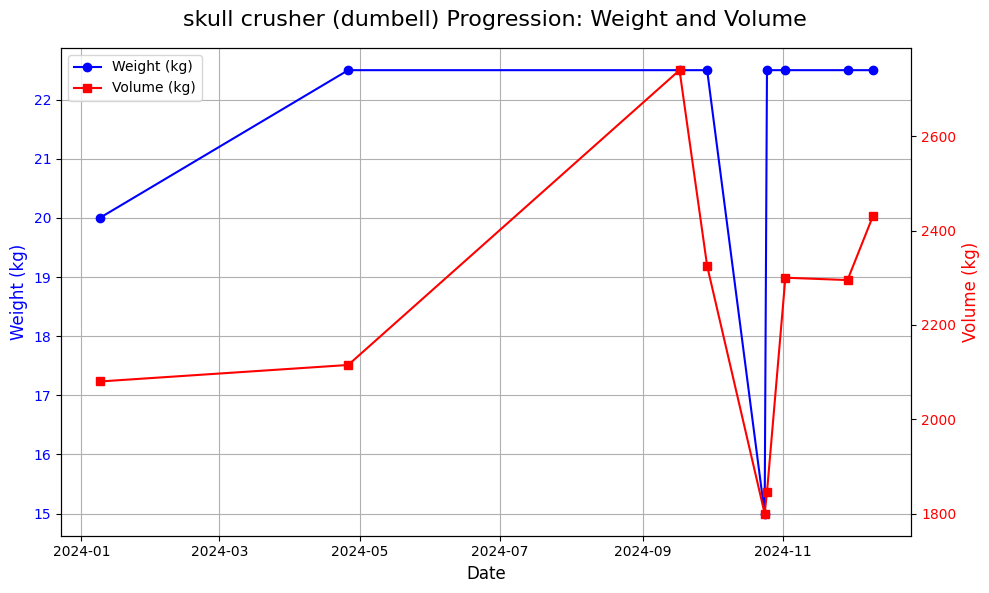

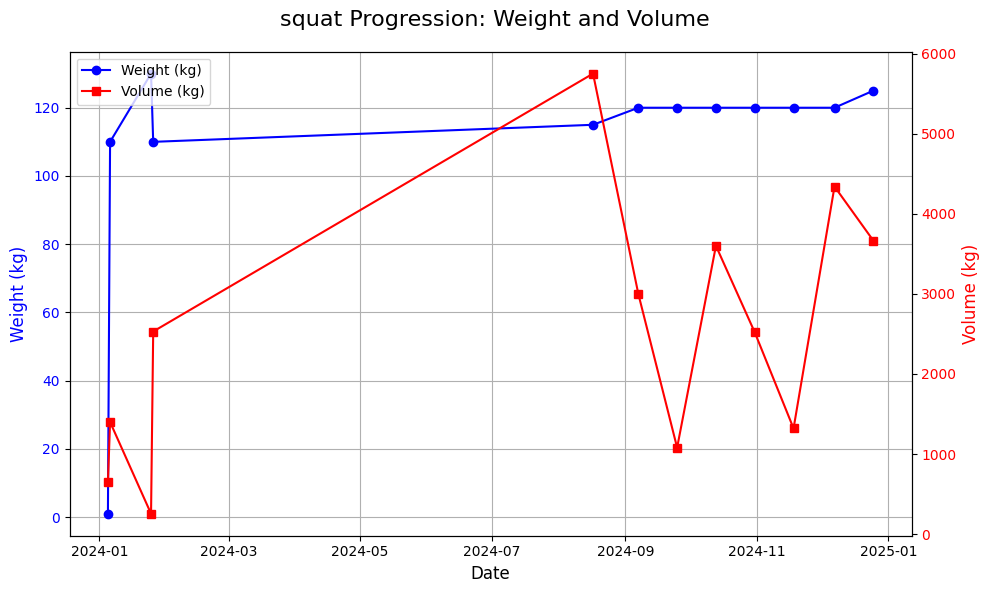

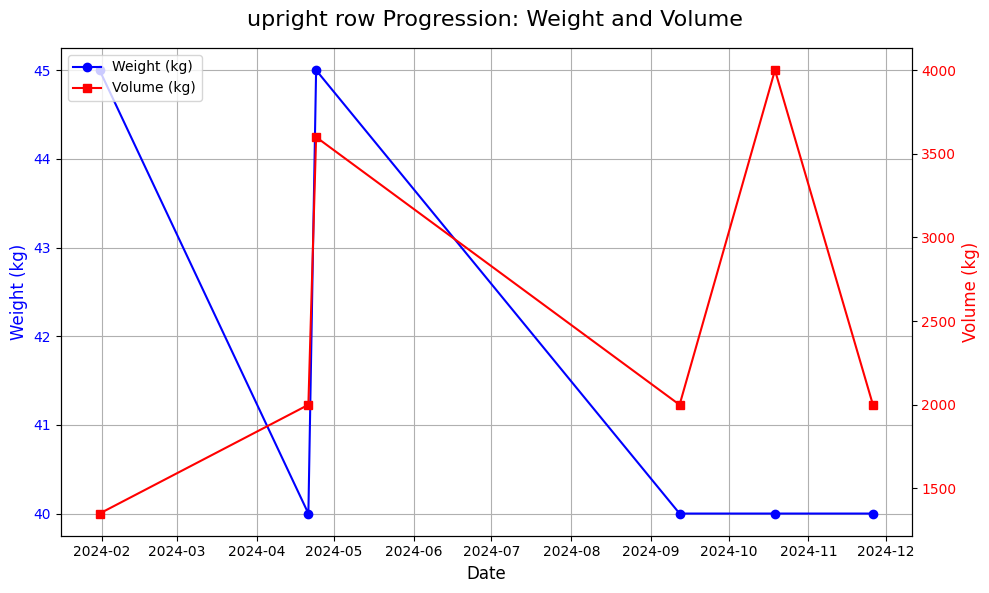

In [49]:
# create a plot visualising each exercise progression in a loop for the year 2024



for exercise in exercises:

    # create a df containing an exercise and dates from 2024
    exercise_2024 = df[
        (df['exercise'] == exercise) &
        (df['date'] >= '2024-01-01' ) &
        (df['date'] <= '2024-12-31' )
        ]

    # volume df
    exercise_volume_2024 = exercise_2024.groupby('date', as_index=False)['volume'].sum()
    exercise_volume_2024 = exercise_volume_2024.rename(columns={'volume': 'total_volume'})

    # Max weight df
    # group the entries by date and only select the one with the highest value for weight_kg
    exercise_max_2024 = exercise_2024.loc[exercise_2024.groupby('date')['weight_kg'].idxmax()]

    # Plotting both volume and max weight for each exercise

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the first DataFrame (weight) on the left y-axis
    ax1.plot(exercise_max_2024['date'], exercise_max_2024['weight_kg'], color='blue', marker='o', label='Weight (kg)')
    ax1.set_ylabel('Weight (kg)', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True)

    # Create the second y-axis sharing the same x-axis
    ax2 = ax1.twinx()  # This creates a second y-axis
    ax2.plot(exercise_volume_2024['date'], exercise_volume_2024['total_volume'], color='red', marker='s', label='Volume (kg)')
    ax2.set_ylabel('Volume (kg)', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # Add titles and legends
    fig.suptitle(f'{exercise} Progression: Weight and Volume', fontsize=16)
    fig.tight_layout()  # Adjust layout to prevent overlap

    # Add a combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.show()